# Detector for Poisoning Attack

---

## Spectral Signatures 

### API Reference:
- https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/detector_poisoning.html#spectral-signature-defense

### Related paper:
- https://proceedings.neurips.cc/paper/2018/file/280cf18baf4311c92aa5a042336587d3-Paper.pdf

### Description
This method is to detect backdoors inputs in training data. In this demo, we show how to use ART to add this defence to a classifier and filter out suspicious training data.

---

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution() # To use the ART
tf.get_logger().setLevel('ERROR')

import tensorflow.keras as tk
import tensorflow.keras.layers as tkl
from tensorflow.keras import datasets, layers, models, Sequential

import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

from art.utils import load_dataset
from art.estimators.classification import KerasClassifier


mnist_model_path = '/archive/workspace/TTA/demo/models/baisc_cnn_mnist'

### Load MNIST dataset

In [4]:
from art.utils import load_mnist, preprocess

(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

### Generate Poisoning dataset

In [5]:
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image

def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources = np.array([0]) # np.arange(10) # 0, 1, 2, 3, ...
    targets = np.array([1]) #(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [6]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

### Train and evalute the model 
Build classification model

In [10]:
model = Sequential()
model.add(tkl.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(tkl.Conv2D(64, (3, 3), activation='relu'))
model.add(tkl.MaxPooling2D(pool_size=(2, 2)))
model.add(tkl.Dropout(0.25))
model.add(tkl.Flatten())
model.add(tkl.Dense(128, activation='relu'))
model.add(tkl.Dropout(0.5))
model.add(tkl.Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Traing the model

In [8]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Train on 7918 samples


2021-12-21 12:24:10.844685: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-21 12:24:11.015033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 12:24:11.015727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 12:24:11.016309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/5


2021-12-21 12:24:12.171115: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


7918/7918 [==============================] - 2s 220us/sample - loss: 0.7817 - accuracy: 0.7497
Epoch 2/5
7918/7918 [==============================] - 0s 62us/sample - loss: 0.2769 - accuracy: 0.9214
Epoch 3/5
7918/7918 [==============================] - 1s 73us/sample - loss: 0.1689 - accuracy: 0.9492
Epoch 4/5
7918/7918 [==============================] - 1s 75us/sample - loss: 0.1325 - accuracy: 0.9607
Epoch 5/5
7918/7918 [==============================] - 1s 70us/sample - loss: 0.1009 - accuracy: 0.9694


Evaluate the model with clean test samples 


Clean test set accuracy: 97.43%


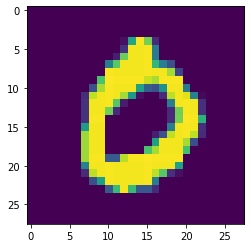

Prediction: 0


In [ ]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

Evaluate the model with poisoning smaples

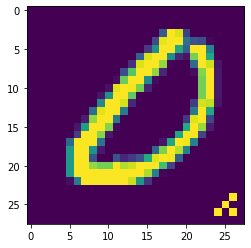

Prediction: 1

 Effectiveness of poison: 100.00%


In [11]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()

poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


In [24]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))


 Overall test set accuracy (i.e. effectiveness of poison): 97.57%


### Defence poisoning attack and evaluate it#

In [25]:
from art.defences.detector.poison import SpectralSignatureDefense

defence = SpectralSignatureDefense(classifier, x_train, y_train, 
                                   batch_size=128, eps_multiplier=1, expected_pp_poison=percent_poison)

In [45]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("------------------- Analysis completed. Report -------------------")
import pprint
from itertools import islice
pp = pprint.PrettyPrinter(indent=10)

num_clean_samples = 0
for l in is_clean_lst: 
    if l == 1:
        num_clean_samples += 1

print('The number of detected samples: ', len(is_clean_lst) - num_clean_samples)
print('The number of clean samples: ', num_clean_samples)
print('Report for detected samples(index: outlier score of suspected poisons: ')
pprint.pprint(dict(islice(report.items(), 10)))

------------------- Analysis completed. Report -------------------
The number of detected samples:  2617
The number of clean samples:  5301
Report for detected samples(index: outlier score of suspected poisons: 
{114: 10.093924,
 137: 12.14958,
 158: 11.895611,
 191: 8.863086,
 249: 9.627647,
 285: 10.463305,
 293: 16.846973,
 326: 8.402059,
 374: 16.846973,
 420: 11.080215}


In [46]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean)

import json
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 49, 'numerator': 34, 'rate': 69.39},
 'FalsePositive': {'denominator': 672, 'numerator': 223, 'rate': 33.18},
 'TrueNegative': {'denominator': 672, 'numerator': 449, 'rate': 66.82},
 'TruePositive': {'denominator': 49, 'numerator': 15, 'rate': 30.61}}
class_1
{'FalseNegative': {'denominator': 71, 'numerator': 47, 'rate': 66.2},
 'FalsePositive': {'denominator': 1196, 'numerator': 394, 'rate': 32.94},
 'TrueNegative': {'denominator': 1196, 'numerator': 802, 'rate': 67.06},
 'TruePositive': {'denominator': 71, 'numerator': 24, 'rate': 33.8}}
class_2
{'FalseNegative': {'denominator': 44, 'numerator': 25, 'rate': 56.82},
 'FalsePositive': {'denominator': 704, 'numerator': 228, 'rate': 32.39},
 'TrueNegative': {'denominator': 704, 'numerator': 476, 'rate': 67.61},
 'TruePositive': {'denominator': 44, 'numerator': 19, 'rate': 43.18}}
class_3
{'FalseNegative': {'denominator': 40, 'numer